In [1]:
#!/usr/bin/env python
# coding: utf-8


import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold,KFold
from sklearn.metrics import roc_auc_score,f1_score,precision_score, recall_score


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def cal(y,oof_lgb,p=0.5):
    print("AUC score: {}".format(roc_auc_score(y, oof_lgb)))
    print("F1 score: {}".format(f1_score(y, [1 if i >= p else 0 for i in oof_lgb])))
    print("Precision score: {}".format(precision_score(y, [1 if i >= p else 0 for i in oof_lgb])))
    print("Recall score: {}".format(recall_score(y, [1 if i >= p else 0 for i in oof_lgb])))

In [2]:
def ks_calc_cross(data,pred,y_label):
    crossfreq = pd.crosstab(data[pred[0]],data[y_label[0]])
    crossdens = crossfreq.cumsum(axis=0) / crossfreq.sum()
    crossdens['gap'] = abs(crossdens[0] - crossdens[1])
    ks = crossdens[crossdens['gap'] == crossdens['gap'].max()]
    return ks,crossdens

def ks_calc_auc(data,pred,y_label):
    fpr,tpr,thresholds= roc_curve(data[y_label[0]],data[pred[0]])
    ks = max(tpr-fpr)
    return ks

def ks_calc_2samp(data,pred,y_label):
    Bad = data.loc[data[y_label[0]]==1,pred[0]]
    Good = data.loc[data[y_label[0]]==0, pred[0]]
    data1 = Bad.values
    data2 = Good.values
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.concatenate([data1,data2])
    cdf1 = np.searchsorted(data1,data_all,side='right')/(1.0*n1)
    cdf2 = (np.searchsorted(data2,data_all,side='right'))/(1.0*n2)
    ks = np.max(np.absolute(cdf1-cdf2))
    cdf1_df = pd.DataFrame(cdf1)
    cdf2_df = pd.DataFrame(cdf2)
    cdf_df = pd.concat([cdf1_df,cdf2_df],axis = 1)
    cdf_df.columns = ['cdf_Bad','cdf_Good']
    cdf_df['gap'] = cdf_df['cdf_Bad']-cdf_df['cdf_Good']
    return ks,cdf_df

In [3]:
train_data_list = ['training_raw data_1.xlsx','training_raw data_0.xlsx']
train_data = pd.DataFrame()
for file in train_data_list:
    _ = pd.read_excel('../data/{}'.format(file))
    if '1' in file:
        _['label'] = 1
        label2 = _.iloc[:,0].values
        _ = _.iloc[:,1:]
    else:
        _['label'] = 0
        _ = _.iloc[:,1:]
    _.columns = ['TI', 'Y', 'NB', 'LA', 'CE', 'CE*', 'PR', 'ND', 'SM', 'EU', 'EU*', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'HF', 'TA', 'TH', 'U', 'label']
    train_data = pd.concat([train_data,_], axis=0)
train_data = train_data.reset_index(drop=True) 

valid = pd.read_excel('../data/{}'.format('application dataset.xlsx'))
valid['label']=np.nan

print('#'*20)
print('miss rate_training data')
print(train_data.isnull().sum() / (valid.shape[0]))
print('#'*20)
print('miss rate_application data')
print(valid.isnull().sum() / (valid.shape[0]))

####################
miss rate_training data
TI       0.203422
Y        0.173985
NB       0.339603
LA       0.084090
CE       0.000000
CE*      0.199314
PR       0.156195
ND       0.008820
SM       0.017451
EU       0.007124
EU*      0.024801
GD       0.024462
TB       0.082997
DY       0.005842
HO       0.078210
ER       0.023180
TM       0.098300
YB       0.034676
LU       0.047265
HF       0.165015
TA       0.415853
TH       0.121744
U        0.116581
label    0.000000
dtype: float64
####################
miss rate_application data
TI       0.153707
Y        0.078474
NB       0.213825
LA       0.140703
CE       0.000678
CE*      0.372922
PR       0.029626
ND       0.010667
SM       0.000641
EU       0.001508
EU*      0.005993
GD       0.000226
TB       0.040594
DY       0.000075
HO       0.020429
ER       0.000452
TM       0.103162
YB       0.000000
LU       0.000000
HF       0.037503
TA       0.388904
TH       0.009498
U        0.004749
label    1.000000
dtype: float64


In [4]:
feas = ['TI', 'Y', 'NB', 'LA', 'CE', 'CE*', 'PR', 'ND', 'SM', 'EU', 'EU*', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'HF', 'TA', 'TH', 'U']
for fea in feas:
    train_data['{}_isnull'.format(fea)] = 0
    valid['{}_isnull'.format(fea)] = 0
    train_data.loc[train_data[fea].isnull(), '{}_isnull'.format(fea)] =1
    valid.loc[valid[fea].isnull(), '{}_isnull'.format(fea)] =1

In [5]:
train_data = train_data.fillna(-99)
valid = valid.fillna(-99)

In [7]:
X_train, X_test = train_test_split(train_data, test_size=0.3, random_state=42)
X_train.to_excel('../res_stage1/training_set.xlsx', index=True)
X_test.to_excel('../res_stage1/test_set.xlsx', index=True)

In [20]:
feas_expode = []
for i in range(len(feas)-1):
    for j in range(i,len(feas)):
        for data in [train_data,valid]:
            data['{}+{}'.format(feas[i],feas[j])] = data[feas[i]]+data[feas[j]]
            data['{}-{}'.format(feas[i],feas[j])] = data[feas[i]]-data[feas[j]]
            data['{}*{}'.format(feas[i],feas[j])] = data[feas[i]]*data[feas[j]]
            data['{}/{}'.format(feas[i],feas[j])] = data[feas[i]]/(data[feas[j]]+1e-10)
#           data['{}^{}'.format(feas[i],feas[j])] = data[feas[i]]**(train_data[feas[j]]+1e-10)

C:\Users\86152\AppData\Local\Temp/ipykernel_111932/2944201306.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}*{}'.format(feas[i],feas[j])] = data[feas[i]]*data[feas[j]]
C:\Users\86152\AppData\Local\Temp/ipykernel_111932/2944201306.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}/{}'.format(feas[i],feas[j])] = data[feas[i]]/(data[feas[j]]+1e-10)
C:\Users\86152\AppData\Local\Temp/ipykernel_111932/2944201306.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [21]:
for i in tqdm(range(len(feas)-2)):
    for j in range(i,len(feas)-1):
        for k in range(j,len(feas)):
            for data in [train_data,valid]:
                data['{}+{}+{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]+data[feas[j]]+data[feas[k]]
                data['{}-{}-{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]-data[feas[j]]-data[feas[k]]
                data['{}*{}*{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]*data[feas[j]]*data[feas[k]]
                data['{}/{}/{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]/(data[feas[j]]+1e-10)/(data[feas[k]]+1e-10)

C:\Users\86152\AppData\Local\Temp/ipykernel_111932/1214209025.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(feas)-2)):


  0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\86152\AppData\Local\Temp/ipykernel_111932/1214209025.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}+{}+{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]+data[feas[j]]+data[feas[k]]
C:\Users\86152\AppData\Local\Temp/ipykernel_111932/1214209025.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{}-{}-{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]-data[feas[j]]-data[feas[k]]
C:\Users\86152\AppData\Local\Temp/ipykernel_111932/1214209025.py:7: PerformanceWarning: DataFrame is highly fragmented

In [22]:
X_train, X_test = train_test_split(train_data, test_size=0.3, random_state=42)

In [23]:
y = X_train['label']
y_test = X_test['label']
cat_cols = []

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train.shape, X_test.shape

features = list(set(X_train.columns.tolist()) - set(['label','prob']))
print(features)

['SM-ER-TA', 'Y*EU*HO', 'EU+EU+TA', 'CE*-CE*-ER', 'CE*-HF', 'TB*YB*YB', 'YB-LU-U', 'TB+TB+U', 'ER-YB-TA', 'EU**LU*TH', 'TB-HO-TA', 'LA/YB/YB', 'GD/GD/ER', 'CE-CE*-LU', 'GD/LU/TH', 'CE**ER*YB', 'SM/TB/HO', 'EU*-EU*-LU', 'SM*GD*U', 'CE*/DY/U', 'YB*LU*TA', 'ND+EU*+TB', 'CE*ND*EU*', 'CE**EU**ER', 'LA-HO-TA', 'CE*/HO/YB', 'LA/PR/GD', 'CE*+GD+TA', 'CE**DY*ER', 'ER*TM*TA', 'NB+EU+LU', 'EU+EU*+LU', 'Y-GD-ER', 'CE/TM/U', 'NB+GD+U', 'TM-HF-HF', 'ND+ER+LU', 'ND/ER/HF', 'Y/YB/TH', 'CE-GD-U', 'ER/TM/YB', 'Y/HF', 'HO/HO/TH', 'SM+DY+TA', 'NB/ER/LU', 'ND*EU*HF', 'LA+TH+U', 'PR*EU*GD', 'LA-CE-SM', 'CE*-HO-ER', 'EU*/EU*/YB', 'PR-YB-HF', 'ND+SM+HO', 'Y/DY/LU', 'CE*EU*YB', 'HO*TM*TH', 'ND-GD-GD', 'DY-TA-TH', 'SM*TB*U', 'EU+TB+ER', 'NB*TM*TH', 'DY*HO*HF', 'HF*HF*HF', 'HO-HO-ER', 'LA+HO+U', 'ER-TM-U', 'CE*HF*TH', 'CE*-ND-YB', 'PR-ND-GD', 'Y+YB+YB', 'TI-EU-TM', 'TI+CE*+DY', 'Y/TA/U', 'LA*CE**TB', 'ND/TB/LU', 'TB/DY/TA', 'LA-GD-TB', 'TI*ER*YB', 'PR-GD-LU', 'TI-TH-U', 'Y-CE-YB', 'CE*/EU*/U', 'Y-LA-TA', 'TI-EU*

In [24]:
from sklearn.metrics import f1_score,roc_auc_score
def F1_score(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.where(preds>0.5,1,0)
    f_score = f1_score(labels, preds, average = 'binary')
    return 'f1_score', f_score, True

In [25]:
def lgb_5fold(X_train,X_test,valid,train_data,seed,features_slc):
    
    df_feature_importance = pd.DataFrame()
    df_feature_importance['features'] = features_slc
    df_feature_importance['gain'] = 0

    KF = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
    params = {
              'objective':'binary',
              'metric':'binary_error',  #binary_error
              'learning_rate':0.05, #0.052
              'subsample':0.8, 
              'subsample_freq':3, 
              'num_iterations': 2000, 
              'is_unbalance':True

    }

    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros((len(X_test),5))
    valid_lgb = np.zeros((len(valid),5))
    train_lgb = np.zeros((len(train_data),5))

    for fold_, (trn_idx, val_idx) in enumerate(KF.split(X_train.values, y.values)):
        print("fold n°{}".format(fold_))
        print('trn_idx:',trn_idx)
        print('val_idx:',val_idx)
        trn_data = lgb.Dataset(X_train.iloc[trn_idx][features_slc],label=y.iloc[trn_idx])    
        val_data = lgb.Dataset(X_train.iloc[val_idx][features_slc],label=y.iloc[val_idx])
        num_round = 10000
        clf = lgb.train(
            params,
            trn_data,
            num_round,
            valid_sets = [trn_data, val_data],
            verbose_eval=100,
            early_stopping_rounds=200,  
            categorical_feature=cat_cols,    
            feval=F1_score
        )       
        oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx][features_slc], num_iteration=clf.best_iteration)
        predictions_lgb[:,fold_] = clf.predict(X_test[features_slc], num_iteration=clf.best_iteration)
        valid_lgb[:,fold_]= clf.predict(valid[features_slc], num_iteration=clf.best_iteration)
        train_lgb[:,fold_]= clf.predict(train_data[features_slc], num_iteration=clf.best_iteration)
        df_feature_importance['gain'] += clf.feature_importance()/5
    return oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance

In [26]:
features_slc = features
oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance = lgb_5fold(X_train,X_test,valid,train_data,12,features_slc)
features_slc = df_feature_importance[df_feature_importance['gain']>0].sort_values(by='gain',ascending=False).head(120).features
oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance = lgb_5fold(X_train,X_test,valid,train_data,12,features_slc)
features_slc=list(set(df_feature_importance.sort_values(by='gain', ascending=False)['features']))
print(features_slc)

fold n°0
trn_idx: [    0     1     2 ... 14643 14644 14645]
val_idx: [    7     9    19 ... 14609 14625 14636]


C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1168, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.101242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2592035
[LightGBM] [Info] Number of data points in the train set: 11716, number of used features: 10223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099693 -> initscore=-2.200643
[LightGBM] [Info] Start training from score -2.200643
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00657221	training's f1_score: 0.96809	valid_1's binary_error: 0.0303754	valid_1's f1_score: 0.852893
[200]	training's binary_error: 0.000170707	training's f1_score: 0.999145	valid_1's binary_error: 0.0225256	valid_1's f1_score: 0.886207
[300]	training's binary_error: 8.53534e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0215017	valid_1's f1_score: 0.890052
[400]	training's binary_error:

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.132594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2592148
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 10223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00733976	training's f1_score: 0.964521	valid_1's binary_error: 0.0300444	valid_1's f1_score: 0.853821
[200]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0235575	valid_1's f1_score: 0.879581
[300]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0201434	valid_1's f1_score: 0.894831
[400]	training's binary_error

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.338135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2592155
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 10223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00623026	training's f1_score: 0.969722	valid_1's binary_error: 0.029703	valid_1's f1_score: 0.856672
[200]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0228747	valid_1's f1_score: 0.883478
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0201434	valid_1's f1_score: 0.896309
[400]	training's binary_error: 0	training's f1_score: 1	valid_1'

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.210838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2592097
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 10223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00597423	training's f1_score: 0.97093	valid_1's binary_error: 0.021509	valid_1's f1_score: 0.895522
[200]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0150222	valid_1's f1_score: 0.924658
[300]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0129737	valid_1's f1_score: 0.933099
[400]	training's binary_error: 

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.094526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2592179
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 10223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00716907	training's f1_score: 0.965289	valid_1's binary_error: 0.0269717	valid_1's f1_score: 0.870279
[200]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0191192	valid_1's f1_score: 0.904437
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0177535	valid_1's f1_score: 0.909722
[400]	training's binary_error: 0	training's f1_score: 1	valid_1

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1168, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11716, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099693 -> initscore=-2.200643
[LightGBM] [Info] Start training from score -2.200643
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00990099	training's f1_score: 0.952692	valid_1's binary_error: 0.0317406	valid_1's f1_score: 0.850242
[200]	training's binary_error: 0.000597474	training's f1_score: 0.997012	valid_1's binary_error: 0.0225256	valid_1's f1_score: 0.888514
[300]	training's binary_error: 8.53534e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0204778	valid_1's f1_score: 0.896552
[400]	training's binary_error: 8.

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0116071	training's f1_score: 0.944984	valid_1's binary_error: 0.029703	valid_1's f1_score: 0.861685
[200]	training's binary_error: 0.00102415	training's f1_score: 0.994894	valid_1's binary_error: 0.0163878	valid_1's f1_score: 0.918089
[300]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.013998	valid_1's f1_score: 0.928696
[400]	training's binary_error: 8.5346

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.011351	training's f1_score: 0.946176	valid_1's binary_error: 0.0300444	valid_1's f1_score: 0.858974
[200]	training's binary_error: 0.000682769	training's f1_score: 0.99659	valid_1's binary_error: 0.0170707	valid_1's f1_score: 0.914384
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0153636	valid_1's f1_score: 0.92201
[400]	training's binary_error: 0	training's f1_score: 

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.00955876	training's f1_score: 0.954286	valid_1's binary_error: 0.0232161	valid_1's f1_score: 0.887417
[200]	training's binary_error: 0.000597423	training's f1_score: 0.997015	valid_1's binary_error: 0.015705	valid_1's f1_score: 0.920962
[300]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0122909	valid_1's f1_score: 0.9375
[400]	training's binary_error: 8.534

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0122045	training's f1_score: 0.942315	valid_1's binary_error: 0.0286787	valid_1's f1_score: 0.866242
[200]	training's binary_error: 0.000768115	training's f1_score: 0.996165	valid_1's binary_error: 0.0170707	valid_1's f1_score: 0.914966
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0163878	valid_1's f1_score: 0.917526
[400]	training's binary_error: 0	training's f1_scor

In [27]:
#The selected 120 features are present here. 
#features_slc = ['NB/EU*/HF', 'CE/SM/HF', 'LA*EU**HF', 'CE/EU*/TH', 'Y/NB/ER', 'Y/LA/TB', 'CE/HF/TH', 'PR/ND/TA', 'CE**TH*U', 'Y/TM', 'TI/EU*/TA', 'ER/LU', 'TM/YB/TA', 'PR/EU/U', 'NB/LA/CE*', 'CE-ND-TA', 'Y/CE/TH', 'HF-U', 'NB/HF/U', 'TA/U', 'NB/CE/CE', 'Y/YB', 'EU*/TA/TA', 'ND/GD', 'TI*EU**HF', 'Y/EU*/HF', 'CE/EU/TA', 'TM/LU', 'Y/DY/HF', 'HO/YB', 'TI-EU-TA', 'Y/NB/YB', 'LA-PR-EU*', 'EU/GD/TA', 'ND/EU/TA', 'TI*Y*EU*', 'CE/U', 'EU**HF*TA', 'SM/GD/HF', 'TM/LU/HF', 'Y/YB/HF', 'EU/GD', 'ER-LU-LU', 'CE/HF/U', 'CE+HF+TH', 'HO-LU', 'EU/LU/LU', 'EU**HF*HF', 'LU/TH', 'SM/EU*/TH', 'TI/HF/HF', 'ER/TM/HF', 'Y/CE/EU*', 'CE/EU*/LU', 'Y/DY', 'ER/YB', 'CE/LU', 'TI-NB-CE', 'ND/EU/U', 'YB/LU/HF', 'TI*TI*CE*', 'TI*HF*TA', 'HF-TH-U', 'PR/EU/TA', 'NB*EU**HF', 'YB/LU', 'TB/DY', 'CE/HF/HF', 'TI/NB/EU*', 'TM/YB', 'TI*TI*TA', 'EU/EU*/GD', 'TI*HF*HF', 'Y/HO', 'YB/LU/TA', 'DY/HO', 'TH-U', 'Y/CE/HF', 'CE/EU*/TA', 'EU/LU', 'TM/YB/HF', 'EU/GD/HF', 'CE/EU/HF', 'DY/LU', 'GD/TB', 'TI*TI*HF', 'ER/YB/HF', 'TH/U', 'CE/TH/U', 'Y/ER', 'NB/EU*/EU*', 'SM/GD', 'Y/NB', 'PR/ND', 'CE/TH', 'HO-LU-TA', 'CE/SM/TA', 'CE/GD', 'ER/TM', 'DY-LU-LU', 'SM/EU/TA', 'Y/HO/HF', 'Y/NB/CE', 'ER/TM/TA', 'CE/GD/HF', 'ER/LU/HF', 'DY-LU-TA', 'CE/TA/U', 'TI/EU*/HF', 'Y/LU', 'NB/EU*/U', 'CE/EU*/U', 'DY/HO/TA', 'TM/LU/TA', 'CE/HF/TA', 'Y/NB/DY', 'NB-TA-TA', 'HO/TM', 'HO-TM', 'TB/DY/HF']
#oof_lgb,predictions_lgb,valid_lgb,train_lgb,df_feature_importance = lgb_5fold(X_train,X_test,valid,train_data,12,features_slc)

fold n°0
trn_idx: [    0     1     2 ... 14643 14644 14645]
val_idx: [    7     9    19 ... 14609 14625 14636]


C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1168, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11716, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099693 -> initscore=-2.200643
[LightGBM] [Info] Start training from score -2.200643
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0100717	training's f1_score: 0.951915	valid_1's binary_error: 0.0334471	valid_1's f1_score: 0.842949
[200]	training's binary_error: 0.00051212	training's f1_score: 0.997438	valid_1's binary_error: 0.0238908	valid_1's f1_score: 0.882155
[300]	training's binary_error: 8.53534e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0197952	valid_1's f1_score: 0.900344
[400]	training's binary_error: 8.53

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0116071	training's f1_score: 0.944984	valid_1's binary_error: 0.029703	valid_1's f1_score: 0.861685
[200]	training's binary_error: 0.000938807	training's f1_score: 0.995317	valid_1's binary_error: 0.0153636	valid_1's f1_score: 0.922813
[300]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0153636	valid_1's f1_score: 0.921466
[400]	training's binary_error: 8.53

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0101562	training's f1_score: 0.951567	valid_1's binary_error: 0.0290201	valid_1's f1_score: 0.864434
[200]	training's binary_error: 0.000768115	training's f1_score: 0.996165	valid_1's binary_error: 0.0167293	valid_1's f1_score: 0.916808
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.0143394	valid_1's f1_score: 0.927336
[400]	training's binary_error: 0	training's f1_scor

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.0102415	training's f1_score: 0.95114	valid_1's binary_error: 0.0242404	valid_1's f1_score: 0.883797
[200]	training's binary_error: 0.000512076	training's f1_score: 0.99744	valid_1's binary_error: 0.0153636	valid_1's f1_score: 0.92228
[300]	training's binary_error: 8.53461e-05	training's f1_score: 0.999572	valid_1's binary_error: 0.0136565	valid_1's f1_score: 0.93007
[400]	training's binary_error: 8.53461

C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\86152\anaconda3\envs\python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remo

[LightGBM] [Info] Number of positive: 1169, number of negative: 10548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 11717, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099770 -> initscore=-2.199788
[LightGBM] [Info] Start training from score -2.199788
Training until validation scores don't improve for 200 rounds
[100]	training's binary_error: 0.011351	training's f1_score: 0.946132	valid_1's binary_error: 0.0273131	valid_1's f1_score: 0.871795
[200]	training's binary_error: 0.000512076	training's f1_score: 0.99744	valid_1's binary_error: 0.0167293	valid_1's f1_score: 0.916525
[300]	training's binary_error: 0	training's f1_score: 1	valid_1's binary_error: 0.015705	valid_1's f1_score: 0.92069
[400]	training's binary_error: 0	training's f1_score: 1

In [28]:
predictions_lgb = predictions_lgb.mean(axis=1)

####################
train
AUC score: 0.9940789434408513
F1 score: 0.9262865090403339
Precision score: 0.9413427561837456
Recall score: 0.9117043121149897
####################
test
AUC score: 0.9918296630854219
F1 score: 0.9053571428571429
Precision score: 0.9423791821561338
Recall score: 0.8711340206185567
####################
train confusion matrix
####################
test confusion matrix
####################
positive number in application data:
980


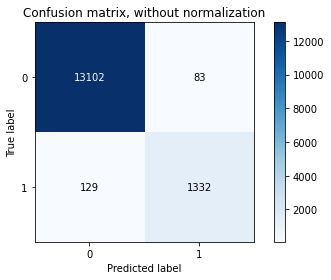

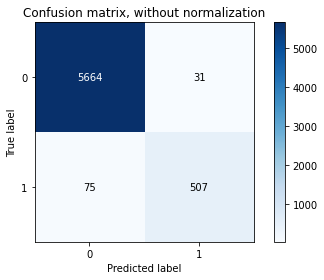

In [29]:
p = 0.5
print('#'*20)
print('train')
cal(y,oof_lgb,p=p)
print('#'*20)
print('test')
cal(y_test.values,predictions_lgb,p=p)

print('#'*20)
print('train confusion matrix')
class_names = np.array(["0","1"])
plot_confusion_matrix(y, [1 if i >= p else 0 for i in oof_lgb], classes=class_names, normalize=False) 

print('#'*20)
print('test confusion matrix')
class_names = np.array(["0","1"])
plot_confusion_matrix(y_test.values, [1 if i >= p else 0 for i in predictions_lgb], classes=class_names, normalize=False)

print('#'*20)
print('positive number in application data:')
print(np.sum([1 if f>=p else 0 for f in valid_lgb.mean(axis=1).tolist()]))

train_data['prob'] = train_lgb.mean(axis=1)
train_data['pred'] = [1 if f>=p else 0 for f in train_lgb.mean(axis=1).tolist()]

valid['prob'] = valid_lgb.mean(axis=1)
valid['pred'] = [1 if f>=p else 0 for f in valid_lgb.mean(axis=1).tolist()]

In [32]:
cols_output = features_slc + ['label','prob','pred']
train_data[cols_output].to_excel('../res_stage1/training data_label.xlsx', index=False)
valid[cols_output].to_excel('../res_stage1/application data_label.xlsx', index=False)
df_feature_importance.sort_values(by='gain', ascending=False).to_excel('../res_stage1/feature importance.xlsx', index=False)

In [33]:
print('#'*20)
print('feature importance：')
print(df_feature_importance.sort_values(by='gain', ascending=False).head(10))

####################
feature importance：
     features   gain
65      YB/LU  207.2
35   TI*Y*EU*  188.0
87       TH/U  185.2
2   LA*EU**HF  178.6
98      ER/TM  174.8
44   CE+HF+TH  173.2
46   EU/LU/LU  172.4
16    Y/CE/TH  171.2
30   TI-EU-TA  167.6
69      TM/YB  162.6


In [34]:
df_index = pd.DataFrame()
df_index['feature'] = features_slc

In [36]:
from sklearn.metrics import roc_curve
from scipy.stats import ks_2samp
print('#'*20)
print('variable_ks')
ks_lst = []
for col in features_slc:
    ks=ks_calc_auc(train_data,[col], ['label'])
#     print('{} ks :{}'.format(col,ks))
    ks_lst.append(ks)
df_index['ks'] = ks_lst
df_index.to_excel('../res_stage1/ks.xlsx', index=False)

####################
variable_ks
